In [1]:
import numpy as np
import sys

In [2]:
e = -100000
X1 = np.linspace(0, 3.0,100)
X2 = np.linspace(0, 1.5, 100)
N1 = X1.shape[0]
N2 = X2.shape[0]
U = np.linspace(-10.0, 10.0, 100)
nU = U.shape[0]
 
J = 1.625103
m = 0.506
M0 = 0.434
L0 = 0.305
R0 = 0.023
B0 = 16.25163
L = 0.0250103
R = 5.0
Kt = 0.90
Kb = 0.90
g = 9.8
M = J + m*L0*L0/3.0 + M0*L0*L0 + 2*M0*R0*R0/5/Kt
N = m*L0*g/2.0 + M0*L0*g/Kt
B = B0/Kt


class SingleLinkManipulatorEnv:
    def _ns(self, x1, x2, a):
        a+=0.1*np.sin(self.t)
        x3 = (a-Kb*x2)/R
        x1dot = x2
        x2dot = -(N/M)*np.sin(x1) - (B/M)*x2 + (x3/M)
        x1p = x1 + 0.1*x1dot
        x2p = x2 + 0.1*x2dot
        self.t+=0.1
        return (x1p, x2p)

    def _quantize(self, x1p, x2p):
        INF = 100000
        d1 = d2 = INF
        x1pd = x2pd = 0
        for i in range(N1):
            if np.abs(x1p - X1[i]) < d1:
                d1 = np.abs(x1p - X1[i])
                x1pd = i
        for j in range(N2):
            if np.abs(x2p - X2[j]) < d2:
                d2 = np.abs(x2p - X2[j])
                x2pd = j
        return (x1pd, x2pd)

    def _reward(self, x1, x2):
        return -np.abs(x1-np.pi/6.0) - np.abs(x2)

    def __init__(self, shape=[N1, N2]):
        self.shape = shape
        self.t = 0
        nS = np.prod(shape)
        nA = nU

        Y_MAX = shape[0]
        X_MAX = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            x, y = it.multi_index
            # print("x: " + str(x))
            # print("y: " + str(y))
            P[s] = {a: [] for a in range(nA)}

            for a in range(nU):
                x1 = X1[x]
                x2 = X2[y]
                x1p, x2p = self._ns(x1, x2, a)
                # returns index wrt X1 and X2
                x1pd, x2pd = self._quantize(x1p, x2p)
                # calculate x1pd and x2pd as a flat array
                ns = (x1pd)*X_MAX + (x2pd)
                
                P[s][a] = [(1.0, ns, self._reward(X1[x1pd], X2[x2pd]), False)]
            it.iternext()
        self.P = P
        self.nS = nS
        self.nA = nA


In [3]:
def value_iteration(env, gamma, eps):
  """
  Arguments:


  env: custom class having the following parameters
    env.P[s][a] is list of transition tuples (p, s_prime, r, terminal)
    env.nS denotes number of states in the env
    env.nA denotes number of actions in the env
  gamma: discount factor
  eps: error epsilon
  
  Returns:

  A tuple (policy, V)
  policy is optimal
  Shape of policy is [S,A]
  V is value function for optimal policy
  """

  def one_step_lookahead(s, V, log = False):
    A = np.zeros(env.nA)
    for a in range(env.nA):
      for p, s_prime, r, terminal in env.P[s][a]:
        if log:
          print(env.P[s][a])
        A[a] += p*(r + gamma * V[s_prime])
    return A
  
  # init v0
  V = np.zeros(env.nS)
  n_iter = 1
  while n_iter <= 200:
    delV = 0
    # full backup for each state
    for s in range(env.nS):
      # find best action at t+1
      A = one_step_lookahead(s, V)
      best_action_value = np.max(A)

      # calc delta and update value function
      delV = max(delV, np.abs(best_action_value - V[s]))
      V[s] = best_action_value
    # print("Value function at iteration: " + str(n_iter)+ ":")
    # print(V.reshape(env.shape))
    n_iter+=1
    # if delV < eps:
    #   break


  policy = np.zeros([env.nS, env.nA])
  # print("Policy Shape: ")
  # print(policy)
  for s in range(env.nS):
    # find best action for state using t+1
    A = one_step_lookahead(s, V, False)
    best_action = np.argmax(A)
    # print("State: "+str(s)+ " => Action: ", end=" ")
    # print(A)
    # greedily take best action
    policy[s, best_action] = 1.0

  return policy, V

In [4]:
env = SingleLinkManipulatorEnv()
  

In [5]:
policy, v = value_iteration(env, 0.99, 0.00001)
# print("Policy")
# print(np.reshape(np.argmax(policy, axis = 1), env.shape))
# print("\nValue Function")
# print(v.reshape(env.shape))
# print(policy)
policy = np.reshape(np.argmax(policy, axis = 1), env.shape)

In [6]:
# Creating Dataset for Training
x_train = np.array([[0.0,0.0]])
y_train = np.array([[0.0]])
for i in range(N1):
    for j in range(N2):
        x_train = np.append(x_train, np.array([[X1[i], X2[j]]]), axis=0)
        y_train = np.append(y_train, np.array([U[policy[i,j]]]))

x_train = x_train[1:]
y_train = y_train[1:]/10.0

In [7]:
from tensorflow import keras
import matplotlib.pyplot as plt


model = keras.Sequential([
    keras.layers.Input(shape=(2,)),
    keras.layers.Dense(50, activation='softplus'),
    keras.layers.Dense(50, activation='softplus'),
    keras.layers.Dense(1, activation='tanh'),
])

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanSquaredError()],
)


2023-02-13 21:45:48.822376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 21:45:48.997368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 21:45:48.997391: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-13 21:45:49.025255: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-13 21:45:49.770301: W tensorflow/stream_executor/platform/de

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


2023-02-13 21:45:51.057978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 21:45:51.058411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 21:45:51.058451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-13 21:45:51.058485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-13 21:45:51.058522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/100
100/100 [==============================] - 0s 1ms/step - loss: 0.2282 - mean_squared_error: 0.2282
Epoch 2/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0992 - mean_squared_error: 0.0992
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0455 - mean_squared_error: 0.0455
Epoch 4/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0253 - mean_squared_error: 0.0253
Epoch 5/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 6/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 7/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 8/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 9/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_squared_error: 0.0084
E

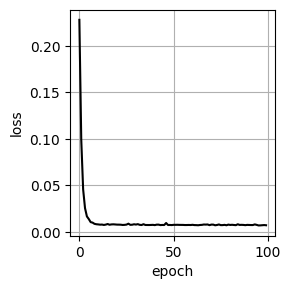

In [8]:
history = model.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=100,
)
f = plt.figure()
# f.set_figwidth(6)
# f.set_figheight(6)
f.set_size_inches(3.25, 3.25)
plt.plot(history.history['loss'], color="black")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.tight_layout(pad=2)
plt.grid(True)
plt.savefig("harmonic_lf/ann_loss.eps", format="eps", dpi=1200)


1/1 [==============================] - 0s 17ms/step


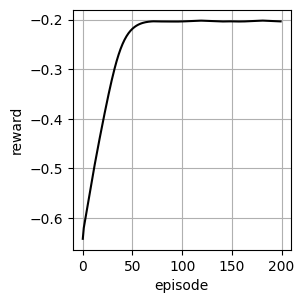

In [9]:
rewards = np.array([])
state = [X1[0], X2[0]]
actions = np.array([])
for eps in range(200):
    act = model.predict((np.atleast_2d(state))).astype(np.float32)[0,0]
    act *=10.0
    actions = np.append(actions, act)
    s_prime = env._ns(state[0], state[1], act)
    state = s_prime
    reward = env._reward(state[0], state[1])
    rewards = np.append(rewards, reward)

f = plt.figure()

# f.set_figwidth(6)
# f.set_figheight(6)
f.set_size_inches(3.25, 3.25)

plt.xlabel("episode")
plt.ylabel("reward")
plt.plot(rewards, color="black")
plt.tight_layout(pad=1.5)
plt.grid(True)
plt.savefig("harmonic_lf/rewards_simulation.eps", format="eps", dpi=1200, bbox_inches='tight')

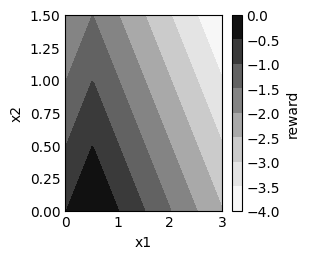

In [10]:
from matplotlib import cm

plt.style.use('_mpl-gallery')

X1m, X2m = np.meshgrid(X1, X2)
Z = env._reward(X1m, X2m)
fig, ax = plt.subplots(1,1)
# fig.set_figheight(6)
# fig.set_figwidth(6)
f.set_size_inches(3.25, 3.25)
cp = ax.contourf(X1m, X2m, Z, cmap="Greys")
cb = fig.colorbar(cp)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
cb.set_label("reward")
# ax.set_xlabel("x1", fontsize=8)
# ax.set_ylabel("x2", fontsize=8)
# ax.set_zlabel("reward", fontsize=8)
# ax.dist=15

plt.savefig("harmonic_lf/reward_plot_over_domain.eps", format="eps", dpi=1200, bbox_inches='tight')

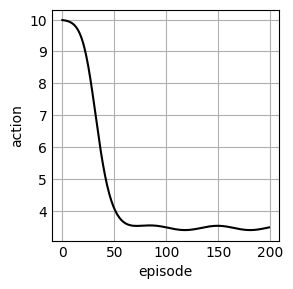

In [11]:
f = plt.figure()
f.set_size_inches(3.25, 3.25)
plt.xlabel("episode")
plt.ylabel("action")
plt.plot(actions, color="black")
plt.tight_layout(pad=2)
plt.grid(True)
plt.savefig("harmonic_lf/control_plot.eps", format="eps", dpi=1200)
